In [1]:
import pandas as pd
import os
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
import numpy as np
print(os.getcwd())
os.chdir('./../')
print(os.getcwd())

d:\Kike\UNI\1º\Introduccion a la ciencia de datos\Practicas\notebooks
d:\Kike\UNI\1º\Introduccion a la ciencia de datos\Practicas


# Aprendizaje no supervisado

NO se dispone de una variable objetivo.

El objetivo es etiquetar a los datos con las características disponibles en el propio dataset.

## Algoritmos de agrupación o clustering
- K-means
- DBSCAN
- Jerárquico
- Muchos más: [Algoritmos implementados Scikit learn](https://scikit-learn.org/stable/modules/clustering.html)


## Funciones de comparación
- Distancia euclídea
- Distancia Manhattan
- Distancia de Chebychev

## Validación
Mucha complejidad en la validación de las agrupaciones.

Se necesita una validación del resultado haciendo uso de métricas y visualización.

# Objetivo en la práctica

1. Analizar la distribución de las estaciones buscando agrupaciones según su posición en la ciudad y la demanda que tienen en uso de bicicletas.
2. Aplicar técnicas de transformación de datos y búsqueda de parámetros óptimos para obtener agrupaciones de estaciones.


In [42]:
df = pd.read_csv('./data/interim/estaciones.csv')
df.tail()
print(df.shape)
df.head()

(273, 9)


,number,uso_bici,address,lat,lon,total,nombre,coddistrit,codbarrio
0,1,1078,C/GUILLEM DE CASTRO esquina con C/NA JORDANA,39.480042,-0.382929,25,EL CARME,1,3
1,2,1000,Salvador Giner - C. Museo,39.479889,-0.379748,15,EL CARME,1,3
2,3,1204,Plaza del Musico López Chavarri,39.476835,-0.380288,20,EL CARME,1,3
3,4,1401,Plaza de la Virgen - Bailía,39.476747,-0.375342,25,LA SEU,1,1
4,5,996,Plaza Poeta Llorente,39.476895,-0.371140,15,LA XEREA,1,2


In [44]:
dfsel = df.loc[df['nombre']=='RUSSAFA', :].copy()
dfsel.tail()

,number,uso_bici,address,lat,lon,total,nombre,coddistrit,codbarrio
37,38,1361,Peris y Valero - Cabo Jubi,39.459402,-0.370249,15,RUSSAFA,2,1
38,39,1306,Peris y Valero - Cuba,39.457854,-0.373931,19,RUSSAFA,2,1
145,148,0,C/Xàtiva 30-32,39.467145,-0.375378,35,RUSSAFA,2,1
149,152,1118,Reina Doña María - Cádiz,39.460925,-0.372705,15,RUSSAFA,2,1
153,156,1221,Puerto Rico - Cuba,39.460964,-0.376345,15,RUSSAFA,2,1


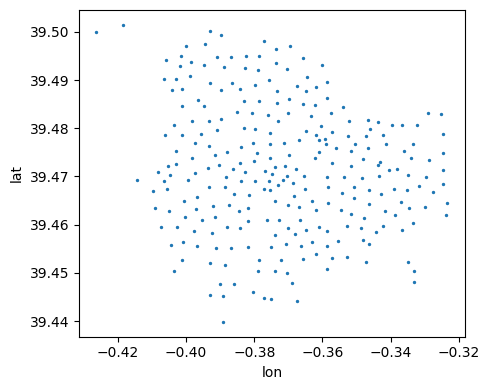

In [49]:
x_feat, y_feat = 'lon', 'lat'
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(df[x_feat], df[y_feat], s=2)
plt.ylabel(y_feat)
plt.xlabel(x_feat)
fig.tight_layout()
plt.show()

In [48]:
lscol = ['uso_bici', 'lat', 'lon']
df.loc[:, lscol]
df.columns

Index(['number', 'uso_bici', 'address', 'lat', 'lon', 'total', 'nombre',
       'coddistrit', 'codbarrio'],
      dtype='object')

In [50]:
lscol = ['uso_bici', 'lat', 'lon']
min_max_scaler = preprocessing.MinMaxScaler()
minmx = min_max_scaler.fit(dfsel.loc[:, lscol])
df2gm = pd.DataFrame(minmx.transform(dfsel.loc[:, lscol]), columns=lscol)
df2gm

,uso_bici,lat,lon
0,1.000000,0.749549,0.237765
1,0.956606,0.331885,1.000000
2,0.881477,0.166589,0.615463
3,0.845855,0.000000,0.243721
4,0.000000,1.000000,0.097640
5,0.724093,0.330538,0.367501
6,0.790803,0.334736,0.000000


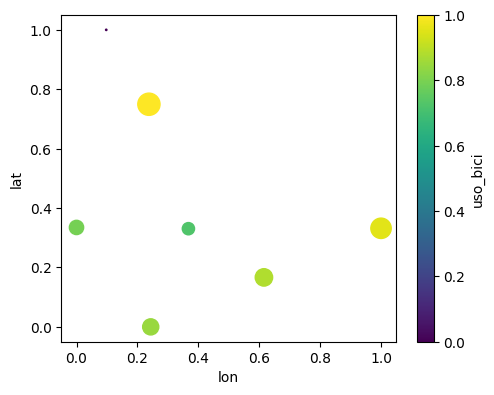

In [51]:
x_feat, y_feat, size = 'lon', 'lat', 'uso_bici'
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax = ax.scatter(df2gm[x_feat], df2gm[y_feat], s=(df2gm[size]+1)**8, c=df2gm[size], cmap='viridis')
plt.ylabel(y_feat)
plt.xlabel(x_feat)
fig.tight_layout()
cbar = plt.colorbar(ax)
cbar.set_label(size)
plt.show()

# Agrupación jerárquica
- Dendogramas, ordenación por distancias de las instancias y agrupación
- Calculo de matriz de similitud en función distancia
- Uso de variables numéricas
- No se define a priori un número de agrupaciones o k
- Se puede generar agrupaciones teniendo en cuenta diferentes parámetros
- Con el método single se pueden detectar outliers 

[Ejemplo visual de clustering](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

[Explicación de clustering jerárquico](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)



In [52]:
def agrupacion_jerarquica(df, ls_cols, dist=3, method='ward',
                          metric='euclidean', optimal_ordering=False):
    mosaicstr="""
    ab
    ab
    cb
    """
    fig, ax = plt.subplot_mosaic(mosaic=mosaicstr, figsize=(10, 6))
    # relacion entre pares de instancias, distancia y acumulado
    # Metodo aglomerativo, no divisivo
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    Z = linkage(df.loc[:, ls_cols].values, method, 
                metric, optimal_ordering=optimal_ordering)
    dendrogram(Z, ax=ax['a'], color_threshold=dist)
    ax['a'].axhline(y=dist, color='r', linestyle='--')
    ax['a'].set_title(f"Dendograma - método {method}")
    ax['a'].set(xlabel='Estación', ylabel='Distancia')
    agglo_clusters = fcluster(Z, t=dist,criterion='distance')
    print("Nº Clusters: ", np.unique(agglo_clusters).shape[0])
    ax['b'].set_title(f"Clustering distribution k={np.unique(agglo_clusters).shape[0]}")
    ax['b'].set(xlabel=ls_cols[0], ylabel=ls_cols[1])
    axb = ax['b'].scatter(df[ls_cols[0]], df[ls_cols[1]], 
                          c=agglo_clusters, cmap='Dark2', s=6)
    cbar = plt.colorbar(axb)
    cbar.set_label('k-clusters')
    ax['c'].plot(Z[:, 2])
    ax['c'].axhline(y=dist, color='r', linestyle='--')
    # ax['c'].set_title(f"Distancia en la aglomeración")
    ax['c'].set(xlabel='Nº estaciones acumuladas', ylabel='Distancia')
    fig.tight_layout()
    plt.show()

Se pide buscar los mejores parámetros en:
- method: single, complete, average o ward
- metric: euclidean, mahalanobis o cityblock

method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

metric: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

Nº Clusters:  7


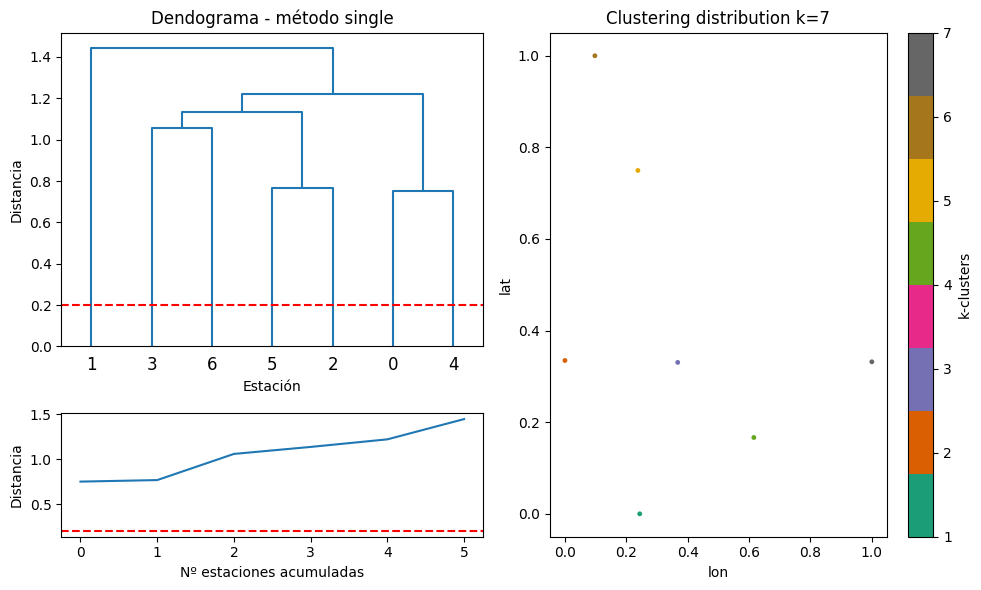

In [53]:
# Se busca ajustar por distancias la mejor agrupación
# metodos: single (minima distancia), complete (maxima distancia), average, ward
ag = agrupacion_jerarquica(df=df2gm, dist=0.2, ls_cols=['lon', 'lat'], 
                           method='single', metric='mahalanobis', 
                           optimal_ordering=True)

Nº Clusters:  3


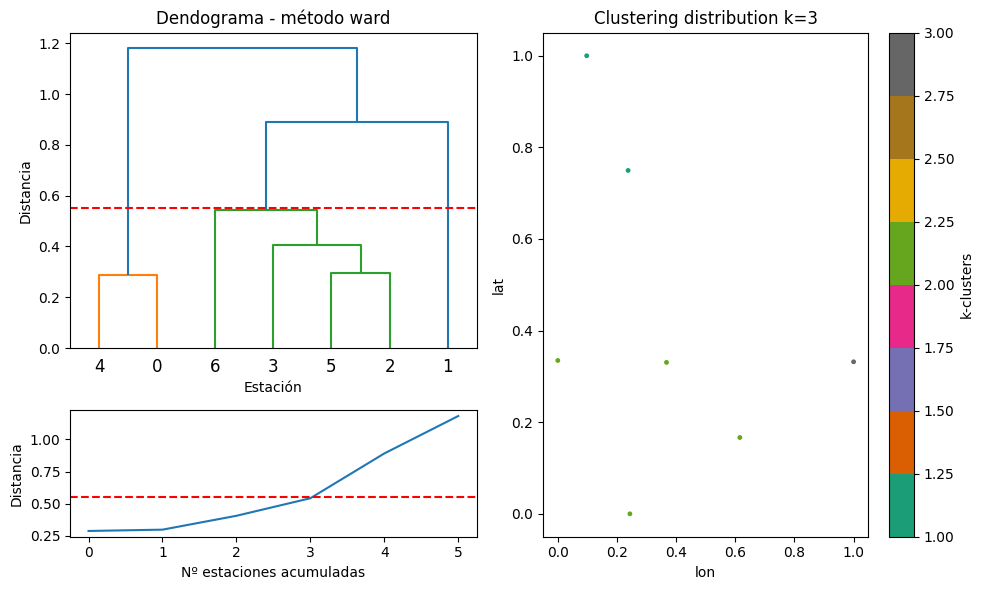

In [60]:
agrupacion_jerarquica(df=df2gm, ls_cols=['lon', 'lat'], 
                      method='ward', 
                      dist=0.55, metric='euclidean', optimal_ordering=True)

Nº Clusters:  14


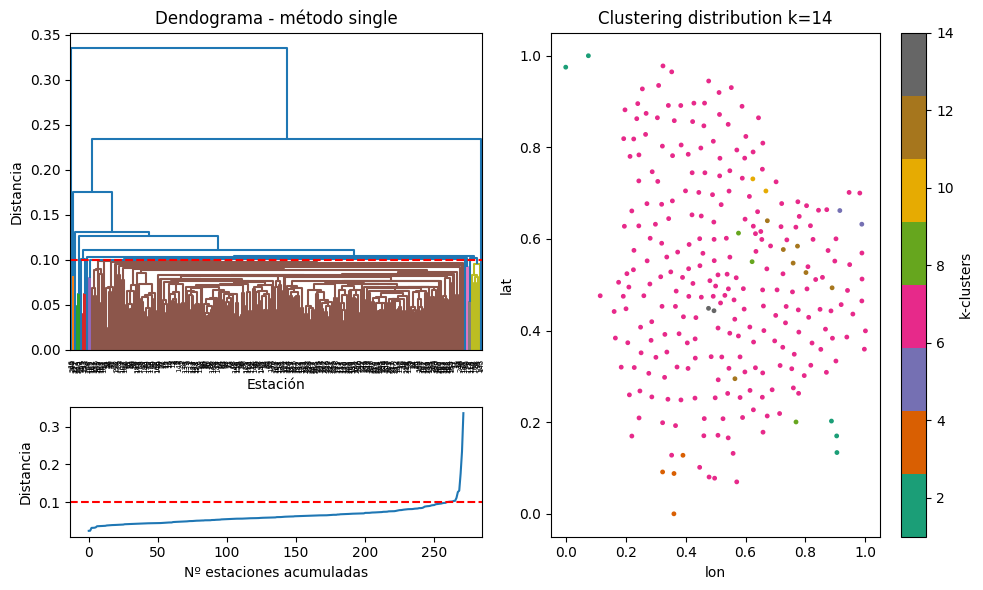

In [10]:
# Incluimos la variable de uso de bicis
agrupacion_jerarquica(df=df2gm, dist=0.1, 
                      ls_cols=['lon', 'lat', 'uso_bici'], 
                      method='single', metric='euclidean', optimal_ordering=True)

Nº Clusters:  11


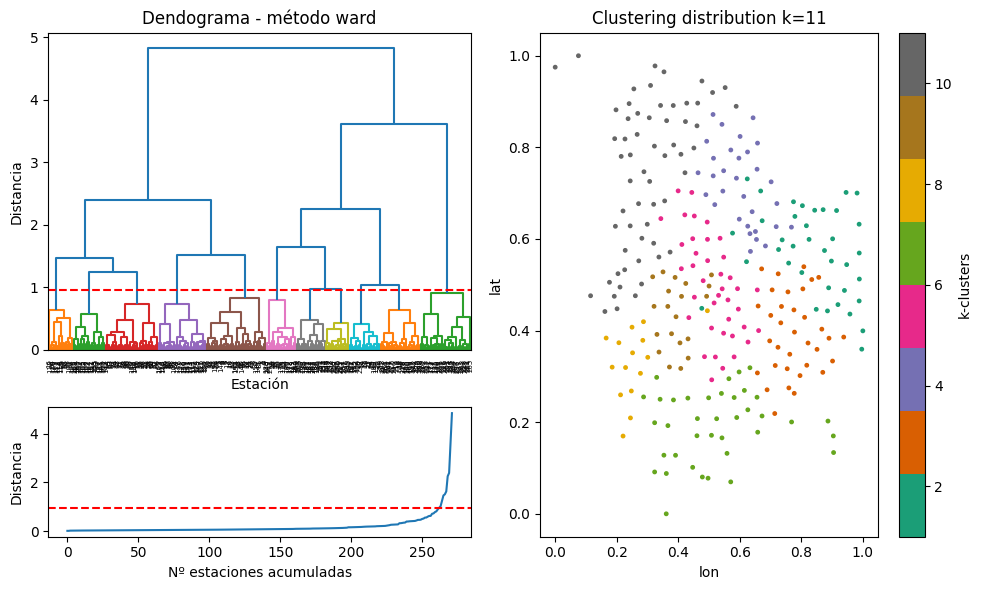

In [36]:
# Comparamos sin aplicar escalado
agrupacion_jerarquica(df=df2gm, dist=0.95, ls_cols=['lon', 'lat', 'uso_bici'], 
                      method='ward', metric='euclidean', optimal_ordering=True)

# Kmeans
## Parametrización
- La inicialización es importante, pero la implementación en SKlearn
- Se define un número de agrupaciones objetivo antes del cálculo
- Es iterativo y tiene una complejidad de cáculo alta

## Evaluación
Existen diferentes métricas aplicables como en el clustering jerárquico:
- Coeficiente de silueta
- Davies-Bouldin
- Inercia o distorsión


In [12]:
df2gm

,uso_bici,lat,lon
0,0.432237,0.652642,0.421284
1,0.400962,0.650161,0.452208
2,0.482759,0.600597,0.446958
3,0.561748,0.599169,0.495042
4,0.399358,0.601571,0.535893
...,...,...,...
268,0.269848,0.662073,0.914556
269,0.136327,0.170034,0.904036
270,0.086608,0.133761,0.904853
271,0.167602,0.202492,0.886605


In [13]:
def plot_kmeans(df, max_k=10):
    """
    Plots KMeans clustering and the elbow method for determining the optimal k.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        max_k (int): Maximum number of clusters to test.
    """
    ls_cols = ['lon', 'lat', 'uso_bici']
    X = df.loc[:, ls_cols].values

    # Calculate inertia for different values of k
    inertia = []
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=22, n_init="auto").fit(X)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Plotting
    mosaicstr = """
    ab
    """
    fig, ax = plt.subplot_mosaic(mosaic=mosaicstr, figsize=(10, 5))

    # Plot KMeans clustering for the last k
    kn = max_k #using the max_k for the final plot.
    kmeans = KMeans(n_clusters=kn, random_state=22, n_init="auto").fit(X)
    labels1 = kmeans.labels_
    centroids1 = kmeans.cluster_centers_

    ax['b'].set_title(f"Clustering distribution k={kn}")
    ax['b'].set(xlabel=ls_cols[0], ylabel=ls_cols[1])
    axb = ax['b'].scatter(X[:, 0], X[:, 1], c=labels1, cmap='Dark2', s=10)
    cbar = plt.colorbar(axb)
    cbar.set_label('k-clusters')
    ax['b'].scatter(centroids1[:, 0], centroids1[:, 1], marker='x',
                    s=200, c='black')

    # Codo
    ax['a'].plot(range(2, max_k + 1), inertia, marker='o')
    ax['a'].set_title('Elbow Method')
    ax['a'].set_xlabel('Number of clusters (k)')
    ax['a'].set_ylabel('Inertia')

    fig.tight_layout()
    plt.show()
    return kmeans.get_params()


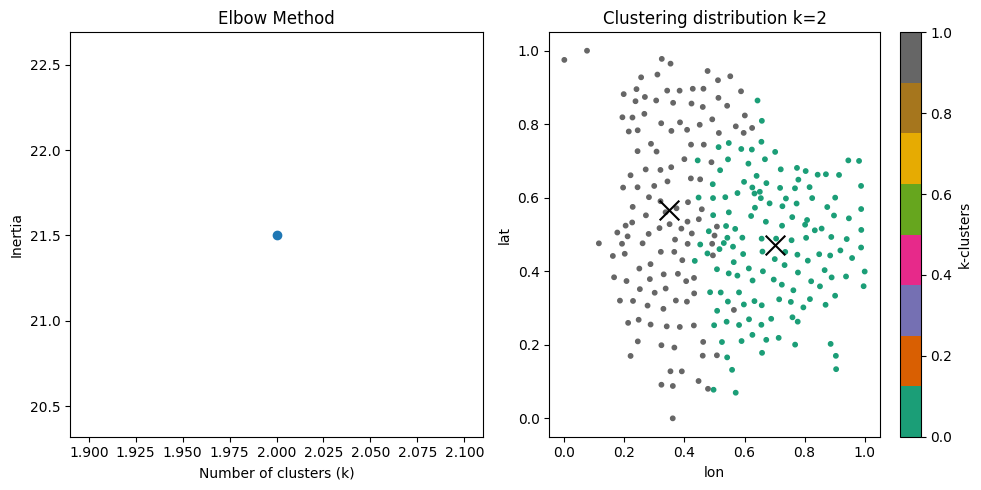

In [14]:
params = plot_kmeans(df2gm, 2)

In [15]:
ls_cols = ['lon', 'lat', 'uso_bici']
X = df2gm.loc[:, ls_cols].values
params['n_clusters'] = 15
kmeans = KMeans(**params).fit(X)
silhouette_score(X, kmeans.labels_), kmeans.inertia_

(np.float64(0.3007741500581341), 3.9439653920829847)

# Conclusiones
- Se prueba el uso de transformaciones para obtener conocimiento 
- Se obtiene agrupaciones que puen ajustarse mejor a las delimitaciones de barrio